In [1]:
import os
from operator import itemgetter    
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
get_ipython().magic(u'matplotlib inline')
plt.style.use('ggplot')

import tensorflow as tf

from keras import models, regularizers, layers, optimizers, losses, metrics
from keras.models import Sequential
from keras.layers import Dense
from keras.utils import np_utils, to_categorical

In [2]:
from keras.datasets import imdb 
top_words = 10000
(train_data, train_labels), (test_data, test_labels) = imdb.load_data(num_words=top_words)

In [3]:
print(train_data,train_data.shape)

[list([1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65, 458, 4468, 66, 3941, 4, 173, 36, 256, 5, 25, 100, 43, 838, 112, 50, 670, 2, 9, 35, 480, 284, 5, 150, 4, 172, 112, 167, 2, 336, 385, 39, 4, 172, 4536, 1111, 17, 546, 38, 13, 447, 4, 192, 50, 16, 6, 147, 2025, 19, 14, 22, 4, 1920, 4613, 469, 4, 22, 71, 87, 12, 16, 43, 530, 38, 76, 15, 13, 1247, 4, 22, 17, 515, 17, 12, 16, 626, 18, 2, 5, 62, 386, 12, 8, 316, 8, 106, 5, 4, 2223, 5244, 16, 480, 66, 3785, 33, 4, 130, 12, 16, 38, 619, 5, 25, 124, 51, 36, 135, 48, 25, 1415, 33, 6, 22, 12, 215, 28, 77, 52, 5, 14, 407, 16, 82, 2, 8, 4, 107, 117, 5952, 15, 256, 4, 2, 7, 3766, 5, 723, 36, 71, 43, 530, 476, 26, 400, 317, 46, 7, 4, 2, 1029, 13, 104, 88, 4, 381, 15, 297, 98, 32, 2071, 56, 26, 141, 6, 194, 7486, 18, 4, 226, 22, 21, 134, 476, 26, 480, 5, 144, 30, 5535, 18, 51, 36, 28, 224, 92, 25, 104, 4, 226, 65, 16, 38, 1334, 88, 12, 16, 283, 5, 16, 4472, 113, 103, 32, 15, 16, 5345, 19, 178, 32])
 list([1, 194, 1153, 194, 8255, 78, 228, 5, 6, 1463, 

Since that neural networks cannot accept integer input, we must first convert text to integers before transforming lists to tensors. To accomplish this, we must first ensure that all the reviews are the same length (in the format of "sample, indices").

now we have to perform one hot encoding to convert integers to binary values

In [4]:
def vectorize_sequences(sequences, dimension=10000):
    results = np.zeros((len(sequences), dimension))
    for i, sequence in enumerate(sequences):
        results[i, sequence] = 1.
    return results

In [5]:
x_train = vectorize_sequences(train_data)
x_test = vectorize_sequences(test_data)
print("x_train ", x_train.shape)
print("x_test ", x_test.shape)
y_train = np.asarray(train_labels).astype('float32')
y_test = np.asarray(test_labels).astype('float32')
print("y_train ", y_train.shape)
print("y_test ", y_test.shape)
y_train=np.asarray(train_labels).astype('float32')
y_test=np.asarray(test_labels).astype('float32')

x_train  (25000, 10000)
x_test  (25000, 10000)
y_train  (25000,)
y_test  (25000,)


In [6]:
print(x_train)
print(train_labels)
print(train_labels.shape)

[[0. 1. 1. ... 0. 0. 0.]
 [0. 1. 1. ... 0. 0. 0.]
 [0. 1. 1. ... 0. 0. 0.]
 ...
 [0. 1. 1. ... 0. 0. 0.]
 [0. 1. 1. ... 0. 0. 0.]
 [0. 1. 1. ... 0. 0. 0.]]
[1 0 0 ... 0 1 0]
(25000,)


In [7]:
# Set a VALIDATION set

x_val = x_train[:10000]
partial_x_train = x_train[10000:]
y_val = y_train[:10000]
partial_y_train = y_train[10000:]

print("x_val ", x_val.shape)
print("partial_x_train ", partial_x_train.shape)
print("y_val ", y_val.shape)
print("partial_y_train ", partial_y_train.shape)

x_val  (10000, 10000)
partial_x_train  (15000, 10000)
y_val  (10000,)
partial_y_train  (15000,)


3 layers with 60 neurons in each layer

In [8]:
model = models.Sequential()
model.add(layers.Dense(60, activation='relu', input_shape=(10000,)))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(60, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(60,activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation='sigmoid'))

The regularization strategy is dropout because a fully connected layer consumes the majority of the parameters, co-dependency between neurons during training diminishes each neuron's own power, and overfitting of the training data is caused by co-dependency between neurons. We use DROPOUT to stop this. Because it is a binary classification problem, the last layer uses the sigmoid activation function.

In [9]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 60)                600060    
                                                                 
 dropout (Dropout)           (None, 60)                0         
                                                                 
 dense_1 (Dense)             (None, 60)                3660      
                                                                 
 dropout_1 (Dropout)         (None, 60)                0         
                                                                 
 dense_2 (Dense)             (None, 60)                3660      
                                                                 
 dropout_2 (Dropout)         (None, 60)                0         
                                                                 
 dense_3 (Dense)             (None, 1)                 6

In [10]:
# FIT / TRAIN model

NumEpochs = 4
BatchSize = 512

model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])

history = model.fit(partial_x_train, partial_y_train, epochs=NumEpochs, batch_size=BatchSize, validation_data=(x_val, y_val))

results = model.evaluate(x_test, y_test)
print("_"*100)
print("Test Loss and Accuracy")
print("results ", results)
history_dict = history.history
history_dict.keys()

Epoch 1/4
30/30 [==============================] - 5s 118ms/step - loss: 0.6343 - acc: 0.6278 - val_loss: 0.4554 - val_acc: 0.8375
Epoch 2/4
30/30 [==============================] - 2s 70ms/step - loss: 0.4199 - acc: 0.8291 - val_loss: 0.3253 - val_acc: 0.8650
Epoch 3/4
30/30 [==============================] - 2s 78ms/step - loss: 0.3050 - acc: 0.8864 - val_loss: 0.2828 - val_acc: 0.8834
Epoch 4/4
782/782 [==============================] - 4s 5ms/step - loss: 0.3015 - acc: 0.8809
____________________________________________________________________________________________________
Test Loss and Accuracy
results  [0.3015216290950775, 0.8808799982070923]


dict_keys(['loss', 'acc', 'val_loss', 'val_acc'])

In [11]:
model = models.Sequential()
model.add(layers.Dense(60, activation='tanh', input_shape=(10000,)))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(60, activation='tanh'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(60,activation='tanh'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation='sigmoid'))
# FIT / TRAIN model

NumEpochs = 4
BatchSize = 512

model.compile(optimizer='rmsprop', loss='mse', metrics=['acc'])

history = model.fit(partial_x_train, partial_y_train, epochs=NumEpochs, batch_size=BatchSize, validation_data=(x_val, y_val))

results = model.evaluate(x_test, y_test)
print("_"*100)
print("Test Loss and Accuracy")
print("results ", results)
history_dict = history.history
history_dict.keys()


Epoch 1/4
30/30 [==============================] - 5s 127ms/step - loss: 0.1801 - acc: 0.7227 - val_loss: 0.1039 - val_acc: 0.8564
Epoch 2/4
30/30 [==============================] - 3s 85ms/step - loss: 0.0987 - acc: 0.8699 - val_loss: 0.0867 - val_acc: 0.8830
Epoch 3/4
30/30 [==============================] - 2s 73ms/step - loss: 0.0820 - acc: 0.8919 - val_loss: 0.0847 - val_acc: 0.8853
Epoch 4/4
782/782 [==============================] - 3s 4ms/step - loss: 0.0902 - acc: 0.8807
____________________________________________________________________________________________________
Test Loss and Accuracy
results  [0.09017698466777802, 0.8806800246238708]


dict_keys(['loss', 'acc', 'val_loss', 'val_acc'])

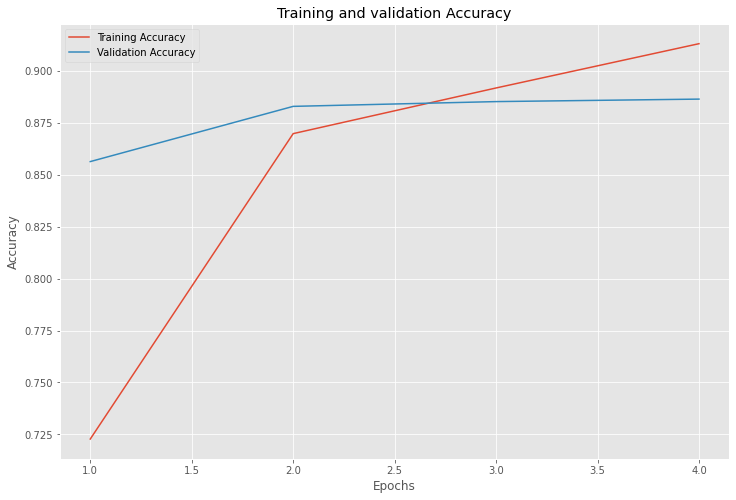

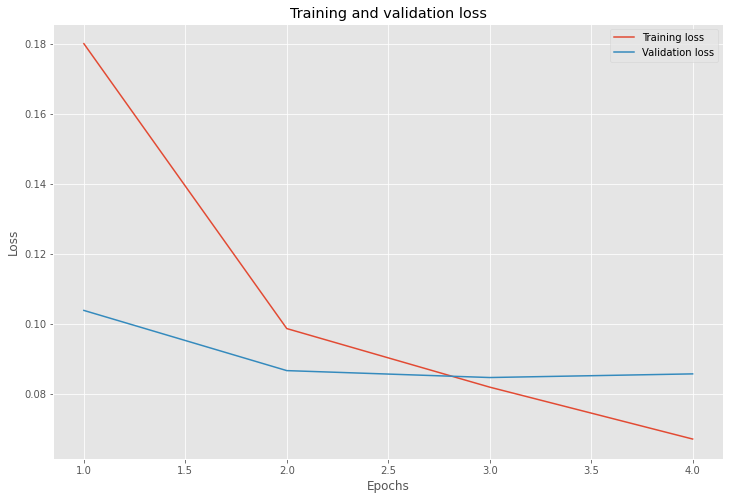

In [12]:
val_loss = history.history['val_loss']
val_acc = history.history['val_acc']
train_loss = history.history['loss']
train_acc = history.history['acc']
plt.figure(figsize=(12,8))
epochs = range(1, len(train_acc) + 1)
plt.plot(epochs, train_acc, label='Training Accuracy')
plt.plot(epochs, val_acc, label='Validation Accuracy')
plt.title('Training and validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()
plt.figure(figsize=(12,8))
epochs = range(1, len(train_acc) + 1)
plt.plot(epochs, train_loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

Overtraining is when validation results start to suffer. In other words, the network is learning both the signal and the noise present in this particular training set in addition to the signal present in the data. To prevent the model from overtraining itself, we decreased the number of epochs from 10 to 4.

2 layers 60 neurons in each layer

In [13]:
model = models.Sequential()
model.add(layers.Dense(60, activation='relu', input_shape=(10000,)))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(60, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation='sigmoid'))
# FIT / TRAIN model

NumEpochs = 4
BatchSize = 512

model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])

history = model.fit(partial_x_train, partial_y_train, epochs=NumEpochs, batch_size=BatchSize, validation_data=(x_val, y_val))

results = model.evaluate(x_test, y_test)
print("_"*100)
print("Test Loss and Accuracy")
print("results ", results)
history_dict = history.history
history_dict.keys()

Epoch 1/4
30/30 [==============================] - 4s 107ms/step - loss: 0.5609 - acc: 0.7117 - val_loss: 0.3899 - val_acc: 0.8506
Epoch 2/4
30/30 [==============================] - 2s 73ms/step - loss: 0.3549 - acc: 0.8645 - val_loss: 0.3112 - val_acc: 0.8740
Epoch 3/4
30/30 [==============================] - 2s 72ms/step - loss: 0.2717 - acc: 0.8964 - val_loss: 0.2784 - val_acc: 0.8869
Epoch 4/4
782/782 [==============================] - 5s 6ms/step - loss: 0.3111 - acc: 0.8741
____________________________________________________________________________________________________
Test Loss and Accuracy
results  [0.31109267473220825, 0.8740800023078918]


dict_keys(['loss', 'acc', 'val_loss', 'val_acc'])

In [14]:
model = models.Sequential()
model.add(layers.Dense(60, activation='tanh', input_shape=(10000,)))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(60, activation='tanh'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation='sigmoid'))
# FIT / TRAIN model

NumEpochs = 4
BatchSize = 512

model.compile(optimizer='rmsprop', loss='mse', metrics=['acc'])

history = model.fit(partial_x_train, partial_y_train, epochs=NumEpochs, batch_size=BatchSize, validation_data=(x_val, y_val))

results = model.evaluate(x_test, y_test)
print("_"*100)
print("Test Loss and Accuracy")
print("results ", results)
history_dict = history.history
history_dict.keys()

Epoch 1/4
30/30 [==============================] - 4s 97ms/step - loss: 0.1765 - acc: 0.7376 - val_loss: 0.1056 - val_acc: 0.8656
Epoch 2/4
30/30 [==============================] - 2s 74ms/step - loss: 0.0976 - acc: 0.8712 - val_loss: 0.0893 - val_acc: 0.8808
Epoch 3/4
30/30 [==============================] - 2s 74ms/step - loss: 0.0758 - acc: 0.8997 - val_loss: 0.0818 - val_acc: 0.8900
Epoch 4/4
782/782 [==============================] - 4s 5ms/step - loss: 0.1053 - acc: 0.8582
____________________________________________________________________________________________________
Test Loss and Accuracy
results  [0.10531435906887054, 0.858240008354187]


dict_keys(['loss', 'acc', 'val_loss', 'val_acc'])

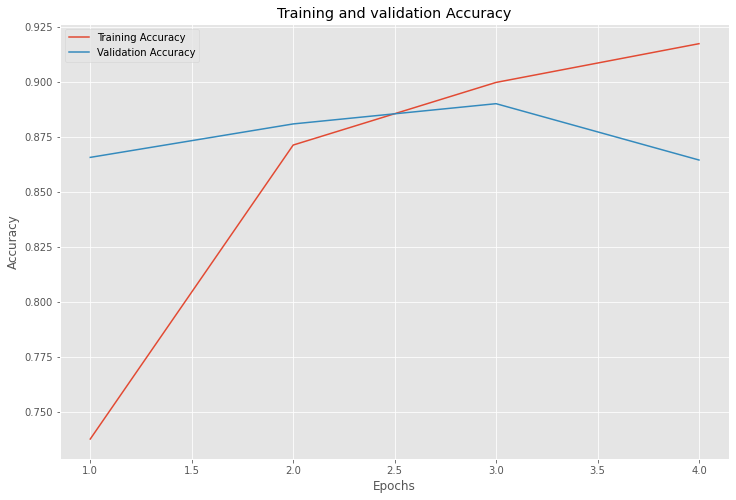

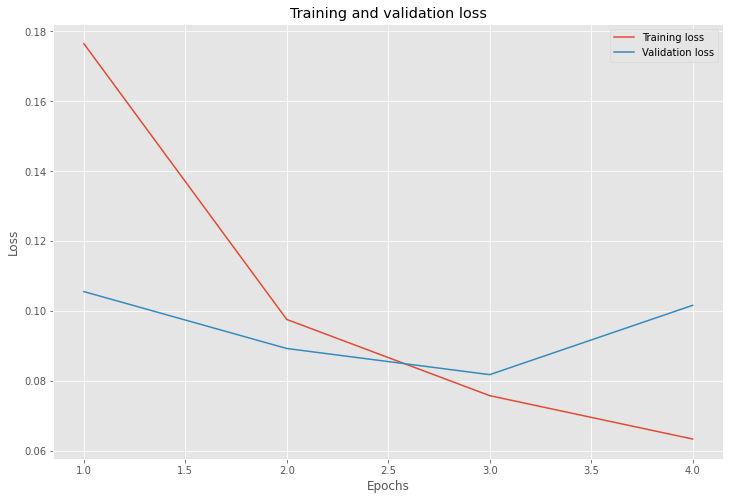

In [15]:
val_loss = history.history['val_loss']
val_acc = history.history['val_acc']
train_loss = history.history['loss']
train_acc = history.history['acc']
plt.figure(figsize=(12,8))
epochs = range(1, len(train_acc) + 1)
plt.plot(epochs, train_acc, label='Training Accuracy')
plt.plot(epochs, val_acc, label='Validation Accuracy')
plt.title('Training and validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()
plt.figure(figsize=(12,8))
epochs = range(1, len(train_acc) + 1)
plt.plot(epochs, train_loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

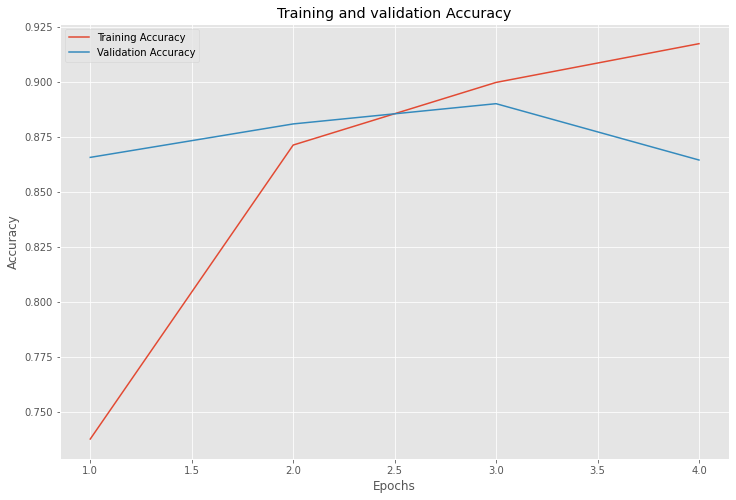

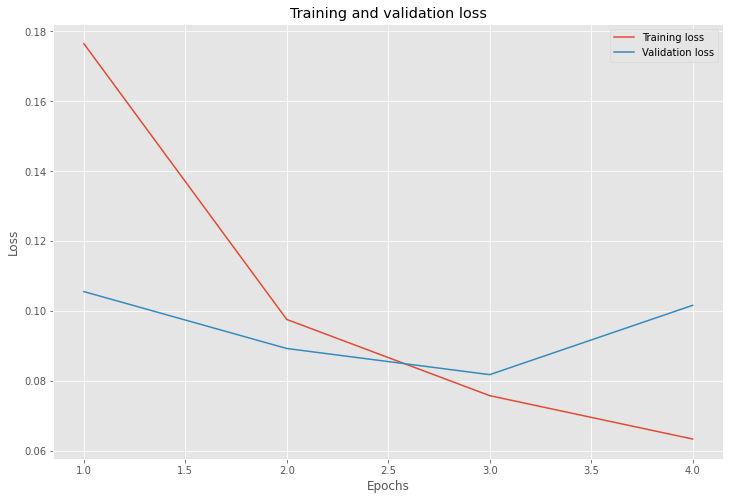

In [16]:
val_loss = history.history['val_loss']
val_acc = history.history['val_acc']
train_loss = history.history['loss']
train_acc = history.history['acc']
plt.figure(figsize=(12,8))
epochs = range(1, len(train_acc) + 1)
plt.plot(epochs, train_acc, label='Training Accuracy')
plt.plot(epochs, val_acc, label='Validation Accuracy')
plt.title('Training and validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()
plt.figure(figsize=(12,8))
epochs = range(1, len(train_acc) + 1)
plt.plot(epochs, train_loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

4 layers with 60 neurons in each layer

In [60]:
model = models.Sequential()
model.add(layers.Dense(60, activation='relu', input_shape=(10000,)))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(60, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(60, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(60, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation='sigmoid'))
# FIT / TRAIN model

NumEpochs = 4
BatchSize = 512

model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])

history = model.fit(partial_x_train, partial_y_train, epochs=NumEpochs, batch_size=BatchSize, validation_data=(x_val, y_val))

results = model.evaluate(x_test, y_test)
print("_"*100)
print("Test Loss and Accuracy")
print("results ", results)
history_dict = history.history
history_dict.keys()

Epoch 1/4
30/30 [==============================] - 4s 102ms/step - loss: 0.6701 - acc: 0.5695 - val_loss: 0.5474 - val_acc: 0.8098
Epoch 2/4
30/30 [==============================] - 2s 78ms/step - loss: 0.4912 - acc: 0.7876 - val_loss: 0.3592 - val_acc: 0.8511
Epoch 3/4
30/30 [==============================] - 2s 77ms/step - loss: 0.3512 - acc: 0.8710 - val_loss: 0.3005 - val_acc: 0.8744
Epoch 4/4
782/782 [==============================] - 4s 6ms/step - loss: 0.3021 - acc: 0.8821
____________________________________________________________________________________________________
Test Loss and Accuracy
results  [0.3021346926689148, 0.8821200132369995]


dict_keys(['loss', 'acc', 'val_loss', 'val_acc'])

In [61]:
model = models.Sequential()
model.add(layers.Dense(60, activation='tanh', input_shape=(10000,)))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(60, activation='tanh'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(60, activation='tanh'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(60, activation='tanh'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation='sigmoid'))
# FIT / TRAIN model

NumEpochs = 4
BatchSize = 512

model.compile(optimizer='rmsprop', loss='mse', metrics=['acc'])

history = model.fit(partial_x_train, partial_y_train, epochs=NumEpochs, batch_size=BatchSize, validation_data=(x_val, y_val))

results = model.evaluate(x_test, y_test)
print("_"*100)
print("Test Loss and Accuracy")
print("results ", results)
history_dict = history.history
history_dict.keys()

Epoch 1/4
30/30 [==============================] - 4s 102ms/step - loss: 0.1928 - acc: 0.6979 - val_loss: 0.0995 - val_acc: 0.8633
Epoch 2/4
30/30 [==============================] - 2s 73ms/step - loss: 0.1087 - acc: 0.8575 - val_loss: 0.0884 - val_acc: 0.8827
Epoch 3/4
30/30 [==============================] - 4s 132ms/step - loss: 0.0856 - acc: 0.8890 - val_loss: 0.0870 - val_acc: 0.8863
Epoch 4/4
782/782 [==============================] - 4s 5ms/step - loss: 0.0930 - acc: 0.8815
____________________________________________________________________________________________________
Test Loss and Accuracy
results  [0.09300673753023148, 0.8814799785614014]


dict_keys(['loss', 'acc', 'val_loss', 'val_acc'])

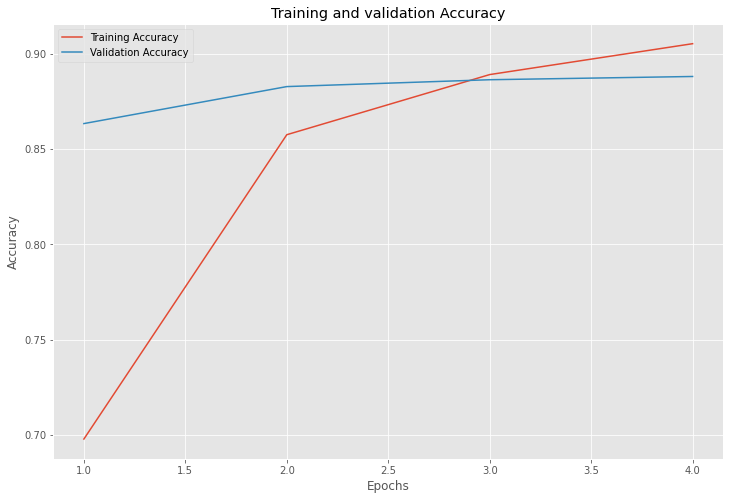

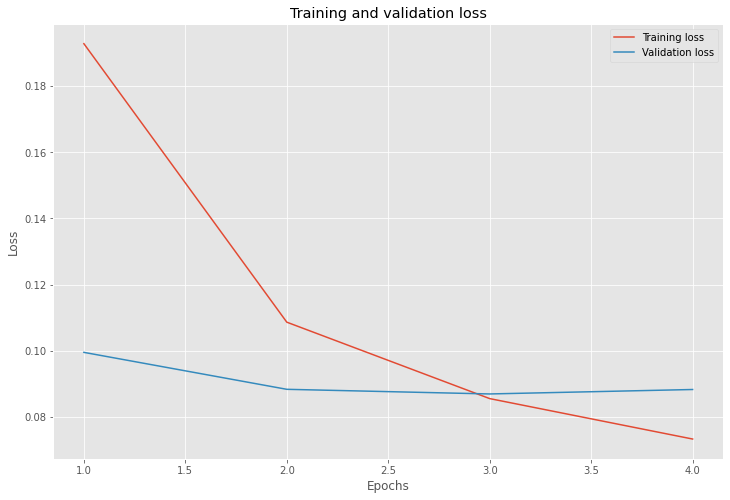

In [62]:
val_loss = history.history['val_loss']
val_acc = history.history['val_acc']
train_loss = history.history['loss']
train_acc = history.history['acc']
plt.figure(figsize=(12,8))
epochs = range(1, len(train_acc) + 1)
plt.plot(epochs, train_acc, label='Training Accuracy')
plt.plot(epochs, val_acc, label='Validation Accuracy')
plt.title('Training and validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()
plt.figure(figsize=(12,8))
epochs = range(1, len(train_acc) + 1)
plt.plot(epochs, train_loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()